In [1]:
import os
import glob
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import csv
import gc
import seaborn as snx
sfreq=250
from mne.decoding import Vectorizer

path = 'C:/BCI_new/oddball'
H_FREQ = 30
L_FREQ = None
from mne.viz import set_browser_backend

set_browser_backend("qt")

Using qt as 2D backend.


## Raw data preprocessing

In [2]:
def tsv_to_fif(subj, run, path=path,
              lpass = None, hpass = 1, sfreq = 250):
    n_channels = 8 # 8 eeg channels + triggers
    stim_code = pd.read_csv(f'{path}/{subj}/stim_code/stim_code_{subj}S00{run}R01.csv')

    data = np.zeros((stim_code.shape[0], n_channels))
    with open(f"{path}/{subj}/raw/{subj}S00{run}R01.ascii") as tsv:
        i = 0
        for line in csv.reader(tsv, dialect="excel-tab"):
            if i == 0:
                columns = line
                i += 1
            elif i <= stim_code.shape[0]:
                data[i-1] = line
                i += 1
    smart = pd.DataFrame(data, columns = columns)
    smart['STIM101'] = stim_code

    # ch_names = columns
    ch_names = list(smart.columns)
    ch_types = ['eeg']*8 + ['stim']
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sfreq)
    raw = mne.io.RawArray(smart.values.T, info)

    path_out = f'{path}/{subj}/preprocessed/'
    os.makedirs(path_out, exist_ok = True)

    raw_filt = raw.copy().filter(
        h_freq=None, l_freq=.1, l_trans_bandwidth='auto', picks = ['eeg'],
        h_trans_bandwidth='auto', filter_length='auto', phase='zero',
        fir_window='hamming', fir_design='firwin', n_jobs=4).notch_filter(
            freqs = np.arange(50,  raw.info['sfreq'] / 2, 50)).notch_filter(
                freqs = np.arange(50,  raw.info['sfreq'] / 2, 50), notch_widths = 2)
    raw_filt.save(f'{path_out}/{subj}S00{run}R01_filt_raw.fif', overwrite = True)
    return raw, raw_filt

In [189]:
def create_epochs(subj, run, path = path):
    file = f'oddball/{subj}/preprocessed/{subj}S00{run}R01_filt_raw.fif'
    filter = False
    if filter:
        raw = mne.io.read_raw_fif(file, preload = True).filter(l_freq = L_FREQ, h_freq = H_FREQ)
    else:
        raw = mne.io.read_raw_fif(file, preload = True)

    st_val = raw._data[-1]
    beg = pd.read_csv(f'{path}/{subj}/stim_code/stim_begin_{subj}S00{run}R01.csv').values[:, 0]
    beg[np.where(np.diff(beg) == 1)[0] + 1] = 100
    beg_st = np.concatenate([st_val[:, None], beg[:, None]], axis = 1)
    eve = []
    ts = []
    for i in range(len(beg_st)):
        if beg_st[i, 1] == 100:
            eve.append(beg_st[i, 0])
            ts.append(i)

    eve = np.array(eve)[:, None]
    zero = np.zeros(len(eve))[:, None]
    ts = np.array(ts)[:, None]

    events = np.concatenate([ts,zero,eve], axis = 1).astype(int)

    trigg = np.arange(2, np.unique(events[:, 2])[-1], 8)
    for i in range(len(events)):
        if events[i, 2] == 1:
            events[i, 2] = -1
        for j in trigg:
            if events[i, 2] == j:
                events[i, 2] = 1001
            elif events[i, 2] == j+1:
                events[i, 2] = 1002
            elif events[i, 2] == j+2:
                events[i, 2] = 1003
            elif events[i, 2] == j+3:
                events[i, 2] = 1004
            elif events[i, 2] == j+4:
                events[i, 2] = 1005
        if events[i, 2] < 1001:
            events[i, 2] = -1

    event_id = {'stim/1' : 1001, 'distr/2' : 1002, 'distr/3': 1003, 'distr/4': 1004, 'distr/5': 1005}

    epochs = mne.Epochs(
        raw,
        tmin=-.2,
        tmax = .5,
        events=events,
        event_id=event_id,
        baseline = None,
        reject_by_annotation=False,
        preload = True
        )

    os.makedirs(f'oddball/{subj}/epochs/', exist_ok=True)
    epochs.save(f'oddball/{subj}/epochs/{subj}_run{run}-epo.fif', overwrite = True)

Creating RawArray with float64 data, n_channels=9, n_times=25839
    Range : 0 ... 25838 =      0.000 ...   103.352 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8251 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Fil

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    0.0s finished
C:\Users\proto\AppData\Local\Temp\ipykernel_8160\2880530207.py:6: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_filt.compute_psd().plot()
C:\Users\proto\AppData\Local\Temp\ipykernel_8160\2880530207.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw_filt.compute_psd().plot()
c:\Users\proto\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Creating RawArray with float64 data, n_channels=9, n_times=25519
    Range : 0 ... 25518 =      0.000 ...   102.072 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8251 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Fil

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    0.0s finished
C:\Users\proto\AppData\Local\Temp\ipykernel_8160\2880530207.py:6: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_filt.compute_psd().plot()
C:\Users\proto\AppData\Local\Temp\ipykernel_8160\2880530207.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw_filt.compute_psd().plot()
c:\Users\proto\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


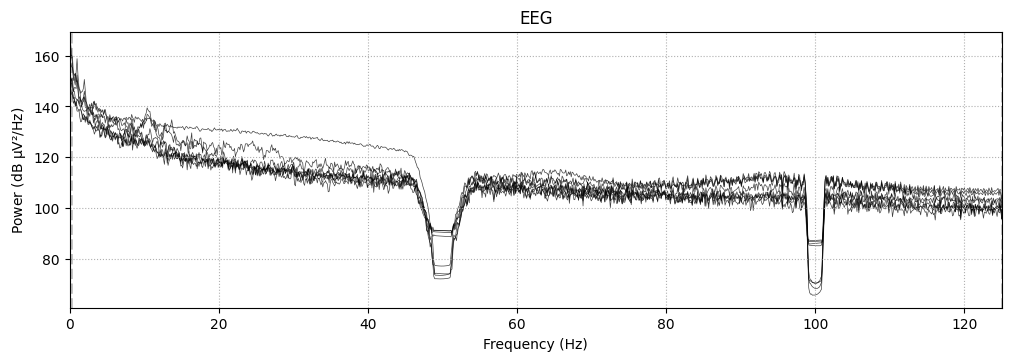

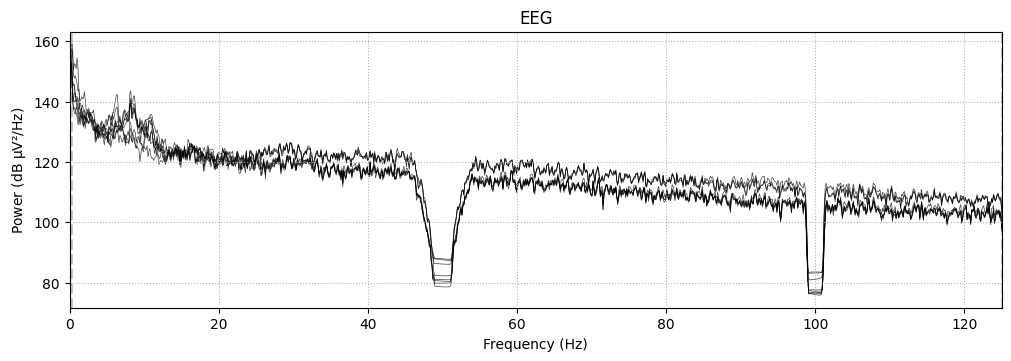

In [199]:
subj = '401'
os.makedirs(f'{path}/{subj}/output/', exist_ok=True)

for run in [1, 2]:
    raw, raw_filt = tsv_to_fif(subj, run = run, path = path)
    fig = raw_filt.compute_psd().plot()
    fig.savefig(f'{path}/{subj}/output/{subj}_0{run}_PSD.png', dpi = 300, bbox_inches = 'tight')

In [200]:
subj = '401'
for run in [1, 2]:
    create_epochs(subj, run)

Opening raw data file oddball/401/preprocessed/401S001R01_filt_raw.fif...
Isotrak not found
    Range : 0 ... 25838 =      0.000 ...   103.352 secs
Ready.
Reading 0 ... 25838  =      0.000 ...   103.352 secs...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 176 original time points ...
0 bad epochs dropped
Opening raw data file oddball/401/preprocessed/401S002R01_filt_raw.fif...
Isotrak not found
    Range : 0 ... 25518 =      0.000 ...   102.072 secs
Ready.
Reading 0 ... 25518  =      0.000 ...   102.072 secs...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 176 original time points ...
0 bad epochs dropped


In [211]:
epo_dct = dict()
for run in [1, 2, 3, 4]:
    epo_dct[run] = []
    for subj in ['201', '301']:
        epochs = mne.read_epochs(f'oddball/{subj}/epochs/{subj}_run{run}-epo.fif', preload = True).apply_baseline((-.2, 0))
        epo_dct[run].append(epochs)
# epochs = mne.concatenate_epochs(epo_all)

Reading c:\BCI_new\oddball\201\epochs\201_run1-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Reading c:\BCI_new\oddball\301\epochs\301_run1-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Reading c:\BCI_new\oddball\201\epochs\201_run2-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Applying b

Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
comp1.max()=502.68291667863434
comp2.max()=529.1238134047564
comp1.max()=208.91846831405866
comp2.max()=338.78899271347944
comp1.max()=127.55305100305408
comp2.max()=178.8278564004337
comp1.max()=218.53689537328833
comp2.max()=235.24236514170966
comp1.max()=56.87436170671501
comp2.max()=65.20603014389965
comp1.max()=980.6874877009906
comp2.max()=1119.8804889753753
comp1.max()=429.586197198606
comp2.max()=1240.0074163698682
comp1.max()=115.53378471366915
comp2.max()=556.607759363511


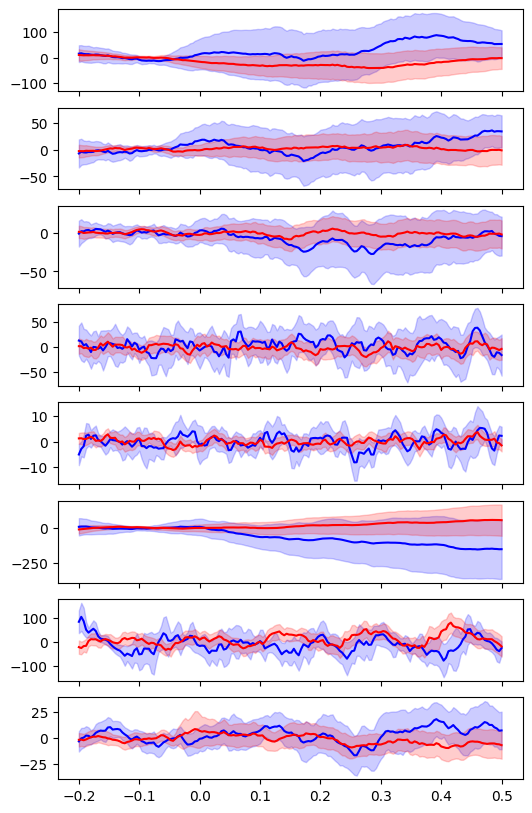

Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
comp1.max()=57.011187250707664
comp2.max()=319.53087212057676
comp1.max()=60.74579870233349
comp2.max()=77.61085603751388
comp1.max()=49.840363019821694
comp2.max()=67.02487726772533
comp1.max()=53.399977986719094
comp2.max()=66.89317871542538
comp1.max()=62.97190643759335
comp2.max()=77.23370968126784
comp1.max()=64.18965719881304
comp2.max()=84.86680157891675
comp1.max()=54.071432930983455
comp2.max()=62.47389497943953
comp1.max()=56.73127760256038
comp2.max()=67.6486192778045


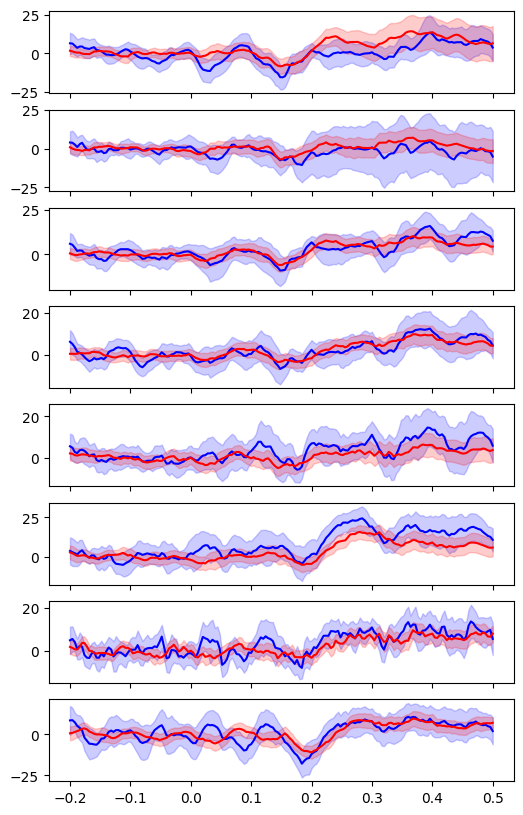

Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
comp1.max()=478.86445435472564
comp2.max()=532.1128197464288
comp1.max()=415.0854306875491
comp2.max()=868.9307765586703
comp1.max()=394.0373304638208
comp2.max()=2466.2494428952537
comp1.max()=650.8861242708037
comp2.max()=6476.6219514959
comp1.max()=272.5781812429903
comp2.max()=217.8709768407485
comp1.max()=1826.0112214929918
comp2.max()=1653.0177591501497
comp1.max()=449.0756966085995
comp2.max()=1548.0865221210556
comp1.max()=596.6452517041973
comp2.max()=2901.521883020214


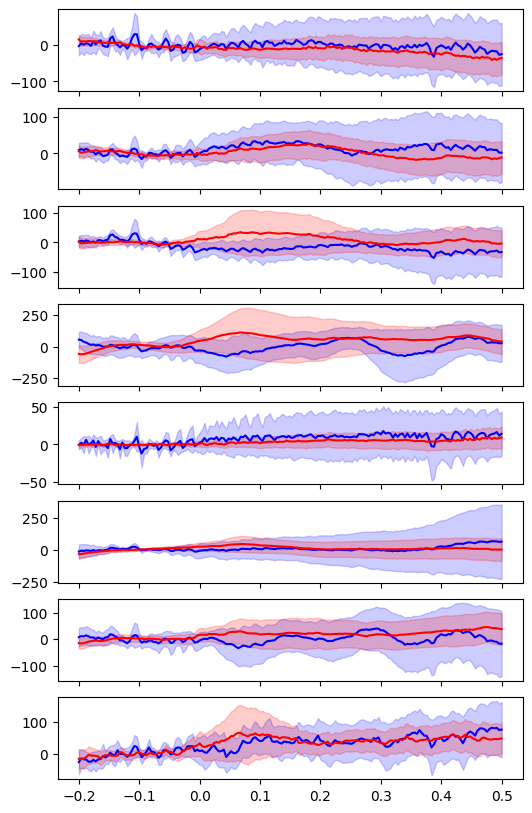

Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
comp1.max()=90.01335742251545
comp2.max()=90.30999095767152
comp1.max()=142.75979408563353
comp2.max()=120.96801787731695
comp1.max()=295.2663342812482
comp2.max()=1893.4384032604742
comp1.max()=138.04012208709528
comp2.max()=110.68144142393973
comp1.max()=167.02375247694698
comp2.max()=108.37389785168217
comp1.max()=115.5404719266237
comp2.max()=186.1222146726122
comp1.max()=91.1846028700763
comp2.max()=132.39806932561538
comp1.max()=67.31313649345847
comp2.max()=183.58780614067527


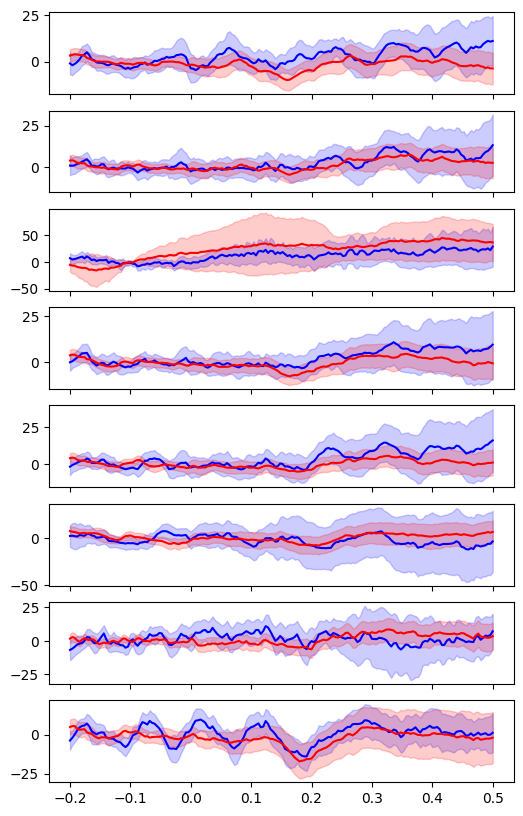

In [213]:
os.makedirs(f'{path}/{subj}/output/', exist_ok=True)

for session in list(epo_dct.keys()):
    epo = mne.concatenate_epochs(epo_dct[session])
    fig, axs = plt.subplots(8, figsize=(6, 10), sharex = True)
    for ch, ch_n in enumerate(epochs.ch_names[:-1]):
        comp1 = epo['stim']._data[:, ch]
        comp2 = epo['distr']._data[:, ch]
        print(f'{comp1.max()=}')
        print(f'{comp2.max()=}')
        axs[ch].plot(epo.times, comp1.mean(axis = 0).T, label = 'target', color = 'blue')
        axs[ch].plot(epo.times, comp2.mean(axis = 0).T, label = 'non-target', color = 'red')
        ci_1 = 1.96 * comp1.std(axis = 0) / len(comp1)**.5
        ci_2 = 1.96 * comp2.std(axis = 0) / len(comp2)**.5
        axs[ch].fill_between(epo.times, (comp1.mean(axis = 0).T-ci_1), (comp1.mean(axis = 0).T+ci_1), color='blue', alpha=.2)
        axs[ch].fill_between(epo.times, (comp2.mean(axis = 0).T-ci_2), (comp2.mean(axis = 0).T+ci_2), color='red', alpha=.2)

    plt.show()
    # fig.savefig(f'{path}/{subj}/output/{subj}_0{session + 1}.png', dpi = 300, bbox_inches = 'tight')

comp1.max()=57.09514071894627
comp2.max()=56.162664348003915
comp1.max()=56.98632497764101
comp2.max()=106.37868137336244
comp1.max()=60.44802041322578
comp2.max()=73.00128027972053
comp1.max()=449.39734636568556
comp2.max()=161.00185147453757
comp1.max()=115.454345703125
comp2.max()=326.080787378199
comp1.max()=127.22357038423127
comp2.max()=433.6626186015121
comp1.max()=656.2102478625727
comp2.max()=184.75315393186082
comp1.max()=103.84151999155681
comp2.max()=146.75987678999994


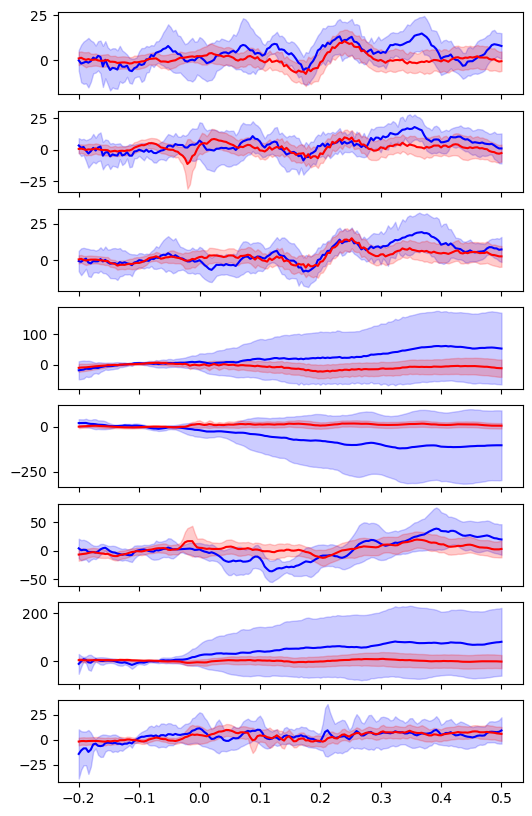

comp1.max()=64.08995928250107
comp2.max()=114.01444645488964
comp1.max()=55.816145385159
comp2.max()=67.05084465765486
comp1.max()=66.89003115833974
comp2.max()=69.67664410670598
comp1.max()=151.10627110799155
comp2.max()=175.44392260383157
comp1.max()=54.458989816553455
comp2.max()=117.14252471923828
comp1.max()=56.952741605394024
comp2.max()=87.54977534682143
comp1.max()=66.81176190399657
comp2.max()=154.3337486304489
comp1.max()=60.29946884512901
comp2.max()=100.6319512759938


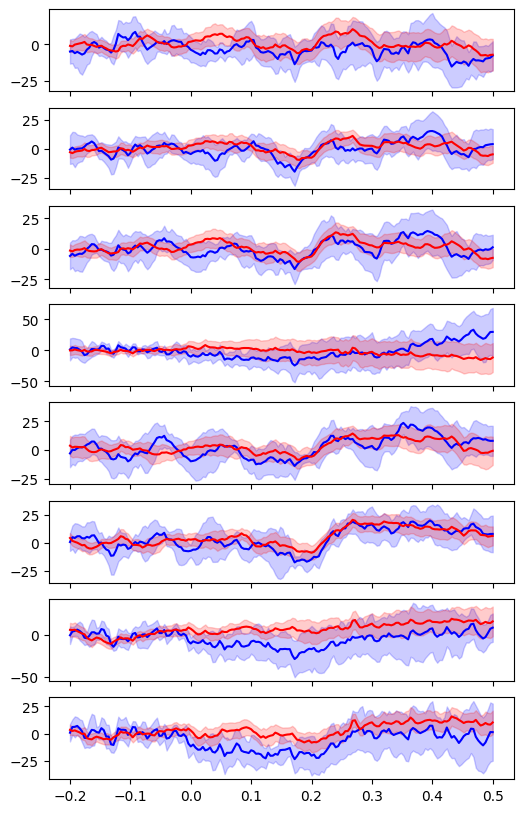

In [ ]:
os.makedirs(f'{path}/{subj}/output/', exist_ok=True)

for session, epo in enumerate(epo_all):
    fig, axs = plt.subplots(8, figsize=(6, 10), sharex = True)
    for ch, ch_n in enumerate(epochs.ch_names[:-1]):
        comp1 = epo['stim']._data[:, ch]
        comp2 = epo['distr']._data[:, ch]
        print(f'{comp1.max()=}')
        print(f'{comp2.max()=}')
        axs[ch].plot(epo.times, comp1.mean(axis = 0).T, label = 'target', color = 'blue')
        axs[ch].plot(epo.times, comp2.mean(axis = 0).T, label = 'non-target', color = 'red')
        ci_1 = 1.96 * comp1.std(axis = 0) / len(comp1)**.5
        ci_2 = 1.96 * comp2.std(axis = 0) / len(comp2)**.5
        axs[ch].fill_between(epo.times, (comp1.mean(axis = 0).T-ci_1), (comp1.mean(axis = 0).T+ci_1), color='blue', alpha=.2)
        axs[ch].fill_between(epo.times, (comp2.mean(axis = 0).T-ci_2), (comp2.mean(axis = 0).T+ci_2), color='red', alpha=.2)

    plt.show()
    fig.savefig(f'{path}/{subj}/output/{subj}_0{session + 1}.png', dpi = 300, bbox_inches = 'tight')

comp1.max()=66.32073998684976
comp2.max()=76.96950335420814
comp1.max()=52.82819619248895
comp2.max()=65.83053882640567
comp1.max()=38.46199734023243
comp2.max()=79.21333879933638
comp1.max()=43.2668214896146
comp2.max()=53.944369241303086
comp1.max()=50.09321147320317
comp2.max()=52.94925352064527
comp1.max()=92.02309316747329
comp2.max()=179.60265739291322
comp1.max()=43.27682022341326
comp2.max()=64.87858322087456
comp1.max()=47.856462464613074
comp2.max()=61.24952484930263


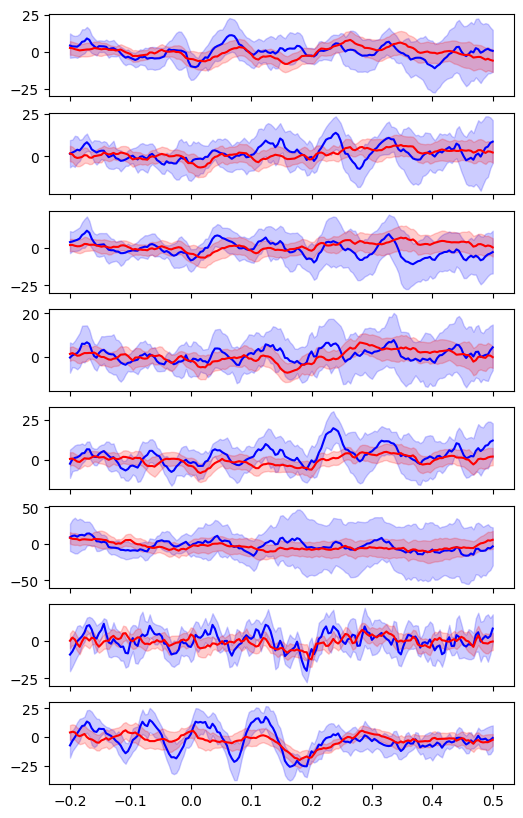

In [ ]:
fig, axs = plt.subplots(8, figsize=(6, 10), sharex = True)
for ch, ch_n in enumerate(epochs.ch_names[:-1]):
    comp1 = epo['stim']._data[:, ch]
    comp2 = epo['distr']._data[:, ch]
    print(f'{comp1.max()=}')
    print(f'{comp2.max()=}')
    axs[ch].plot(epochs.times, comp1.mean(axis = 0).T, label = 'target', color = 'blue')
    axs[ch].plot(epochs.times, comp2.mean(axis = 0).T, label = 'non-target', color = 'red')
    ci_1 = 1.96 * comp1.std(axis = 0) / len(comp1)**.5
    ci_2 = 1.96 * comp2.std(axis = 0) / len(comp2)**.5
    axs[ch].fill_between(epochs.times, (comp1.mean(axis = 0).T-ci_1), (comp1.mean(axis = 0).T+ci_1), color='blue', alpha=.2)
    axs[ch].fill_between(epochs.times, (comp2.mean(axis = 0).T-ci_2), (comp2.mean(axis = 0).T+ci_2), color='red', alpha=.2)

plt.show()
# fig.savefig(f'{path}/output/{subj}_{session}.png', dpi = 300, bbox_inches = 'tight')

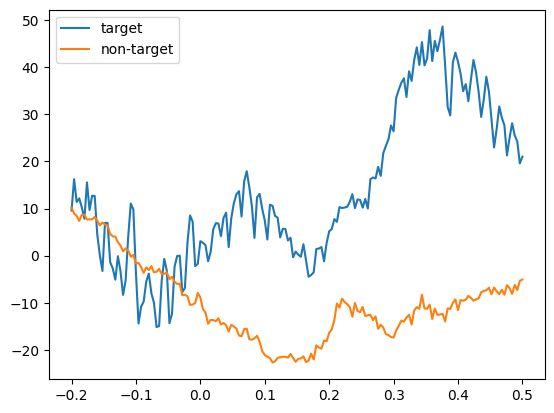

In [132]:
%matplotlib inline
plt.plot(epochs.times, epochs['stim'].average()._data[0].T, label = 'target')
plt.plot(epochs.times, epochs['distr'].average()._data[0].T, label = 'non-target')
plt.legend()